# Project 1

In this preprocessing project I utilized the "London Air dataset" with the goal of predicting the species of the polluter based on the time stamp and the amount of pollution.

Reasoning behind the order of the tasks done in this notebook:
1. Import data first
2. Need to clean data before normalization
- Outliers before aggregation to remove outlier readings. Doing aggregation first would be removing outlier days.
3. Need to normalize data before creating X/Y/train/test sets.
- Label encoding for "Species" since that's what we're trying to predict
- Min-max normalization for aggregated "ReadingDateTime" after it is broken down into month and day.
- Z-score normalization for "Value" because it's a continuous value
4. Saving the dataframe, when it is ready for X/Y split
5. X/Y and train/test splits are the last steps that we need to take
- After these 5 main steps, our team completed the sections from tutorial that did not match our goals for data preprocessing. This was done to ensure that we have a 100% coverage over tutorial using our dataset.

## Helpful functions

In [ ]:
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.abc.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


## 1: Importing the dataset

In [ ]:
import pandas as pd

data = pd.read_csv('./LaqnData.csv') # London air test
data.columns = ['Site', 'Species', 'ReadingDateTime', 'Value', 'Units', 'Provisional or Ratified']

print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 175253
Number of attributes = 6


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,HI0,CO,01/01/2018 00:00,NaN,mg m-3,P
1,HI0,CO,01/01/2018 00:15,NaN,mg m-3,P
2,HI0,CO,01/01/2018 00:30,NaN,mg m-3,P
3,HI0,CO,01/01/2018 00:45,NaN,mg m-3,P
4,HI0,CO,01/01/2018 01:00,NaN,mg m-3,P


## 2: Identifying if the dataset is unclean

In this step our team looks for finding missing values (NaNs) in the dataset.

In [ ]:
# Missing values
import numpy as np

print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

Number of instances = 175253
Number of attributes = 6
Number of missing values:
	Site: 0
	Species: 0
	ReadingDateTime: 0
	Value: 43476
	Units: 0
	Provisional or Ratified: 0


### 2.1: Removing Duplicated Rows


After reviewing the dataset, we found out that there were no duplicated records in the original csv file. Hence, for this section we manually manipulated the file and added duplicated rows to our dataset.


In [ ]:
print('Number of rows before discarding duplicates = %d' % (data.shape[0]))
data = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data.shape[0]))

Number of rows before discarding duplicates = 175253
Number of rows after discarding duplicates = 175200


### 2.2: Dropping the NaN values


In this case, due to large number of NaNs it will be more reasonable to drop them instead of replacing their values with median of the data. However, the commented section in the code below shows the steps to replace the missing values with the median of the data.

In [ ]:
# data2 = data['Value']

# print('Before replacing missing values:')
# print(data2[:10])
# data2 = data2.fillna(data2.median())

# print('\nAfter replacing missing values:')
# print(data2[:10])
print('Number of rows in original data = %d' % (data.shape[0]))

data = data.dropna()
print('Number of rows after discarding missing values = %d' % (data.shape[0]))

Number of rows in original data = 175200
Number of rows after discarding missing values = 131724


### 2.3: Checking the unique values of columns after the initial cleaning.

#### 2.3.1: Checking the "Units" attribute:

In [ ]:
counts = data.groupby('Units').size()
print(counts)

Units
ug m-3           99276
ug m-3 as NO2    32448
dtype: int64


As we observe above, there are only two units used in this dataset: "ug m-3" and "ug m-3 as NO2". Based on our brief research, the only difference that these two have is regarding the substance that they are measuring and are in fact the same. Hence, we can drop this attribute as it will not be useful while training a model.

In [ ]:
data = data.drop('Units', axis=1, inplace=False)
data.head()

,Site,Species,ReadingDateTime,Value,Provisional or Ratified
35040,HI0,NO,01/01/2018 00:00,7.1,R
35041,HI0,NO,01/01/2018 00:15,7.1,R
35042,HI0,NO,01/01/2018 00:30,7.1,R
35043,HI0,NO,01/01/2018 00:45,7.1,R
35044,HI0,NO,01/01/2018 01:00,5.1,R


#### 2.3.2: Checking the "Provisional or Ratified":

In [ ]:
counts = data.groupby('Provisional or Ratified').size()
print(counts)

Provisional or Ratified
R    131724
dtype: int64


As we can observe, the only value in the "Provisional or Ratified" column is R. This is the result of removing records with NaNs as their "Value". All of the records with "R" as their "Provisional or Ratified" were dropped in the early steps of cleaning the dataset due to lack of value.

In [ ]:
data.drop('Provisional or Ratified', axis=1, inplace=True)
data.head()

,Site,Species,ReadingDateTime,Value
35040,HI0,NO,01/01/2018 00:00,7.1
35041,HI0,NO,01/01/2018 00:15,7.1
35042,HI0,NO,01/01/2018 00:30,7.1
35043,HI0,NO,01/01/2018 00:45,7.1
35044,HI0,NO,01/01/2018 01:00,5.1


#### 2.3.3: Checking the "Site":

In [ ]:
counts = data.groupby('Site').size()
print(counts)

Site
HI0    131724
dtype: int64


Since the only site is "HI0" we can drop this column as well.

In [ ]:
data.drop('Site', axis=1, inplace=True)
data.head()

,Species,ReadingDateTime,Value
35040,NO,01/01/2018 00:00,7.1
35041,NO,01/01/2018 00:15,7.1
35042,NO,01/01/2018 00:30,7.1
35043,NO,01/01/2018 00:45,7.1
35044,NO,01/01/2018 01:00,5.1


## 3: Filtering the outliers

In this section we need to find the outliers in our numerical attribute "Value".

### 3.1. Initial observations: Boxplot, and some statistical factors: count, mean, std, min, max, Q1, Q3, and Q2 (median)


,Value
count,131724.000000
mean,48.050503
std,54.252123
min,0.000000
25%,12.500000
50%,33.200000
75%,64.200000
max,643.900020


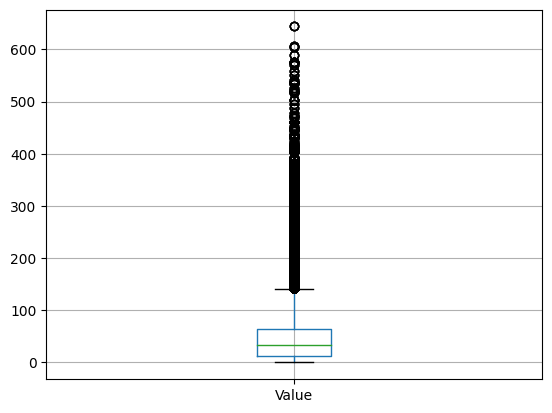

In [ ]:
%matplotlib inline

values = data[['Value']]

values.boxplot()
values.describe()

### 3.2: Methodology of removing the outliers:

By looking at the following histogram and the absense of a bell shaped curve we can conclude that the data (the "Value" attribute) does not have a normal distribution. Hence, instead of removing outliers using Z-scores, we need to use IQR to remove them.

array([[<Axes: title={'center': 'Value'}>]], dtype=object)

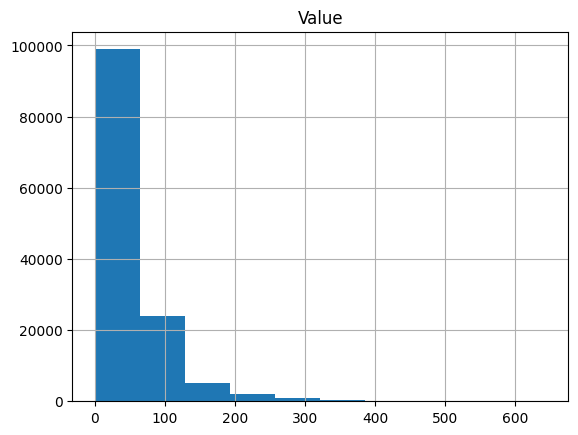

In [ ]:
values.hist()

#### 3.2.1 Removing the outliers using IQR method.

In [ ]:
Q1 = data['Value'].quantile(0.25)
Q3 = data['Value'].quantile(0.75)
IQR = Q3 - Q1
lowerLimit = Q1 - 1.5 * IQR
upperLimit = Q3 + 1.5 * IQR
print('Number of rows before discarding outliers = %d' % (data.shape[0]))
data = data.loc[((data['Value'] > lowerLimit) & (data['Value'] <= upperLimit)),:]

print('Number of rows after discarding outliers = %d' % (data.shape[0]))
data.head()

Number of rows before discarding outliers = 131724
Number of rows after discarding outliers = 124548


,Species,ReadingDateTime,Value
35040,NO,01/01/2018 00:00,7.1
35041,NO,01/01/2018 00:15,7.1
35042,NO,01/01/2018 00:30,7.1
35043,NO,01/01/2018 00:45,7.1
35044,NO,01/01/2018 01:00,5.1


## 4: Standardizing "ReadingDateTime":

Our team decided to perform this step so we can complete the Aggregation afterwards.

In [ ]:
data['ReadingDateTime'] = pd.to_datetime(data['ReadingDateTime'])
data.head()

,Species,ReadingDateTime,Value
35040,NO,2018-01-01 00:00:00,7.1
35041,NO,2018-01-01 00:15:00,7.1
35042,NO,2018-01-01 00:30:00,7.1
35043,NO,2018-01-01 00:45:00,7.1
35044,NO,2018-01-01 01:00:00,5.1


## 5: Aggregation:

The records in this dataset are measurements done each 15 minutes for a year. Our goal is to aggregate data in a way that while preserving the 'Species', we have the measurements based on daily average. The choice of a central tendency measure instead of 'Sum' was mainly because of the early stages of the data cleaning. In this stage we cannot assume that all days, for all species have a set number of recordings.


#### 5.1: Methodology:

5.1.1. Breaking down the dataset: In this steps our team will divide the dataset into multiple datasets based on their 'Species'. First we need to find diffrent species:

In [ ]:
counts = data.groupby('Species').size()
print(counts)

Species
NO     31652
NO2    32380
NOX    26180
O3     34336
dtype: int64


Hence, we will have the following 4 sub datasets that we will concatenate later on.

In [ ]:
NOdata = data.loc[data['Species'] == 'NO',:]
NO2data = data.loc[data['Species'] == 'NO2',:]
O3data = data.loc[data['Species'] == 'O3',:]
NOXdata = data.loc[data['Species'] == 'NOX',:]

5.1.2: Aggregation based on Daily mean of the data performed on all four sub datasets, as specified earlier.

In [ ]:
NO_daily_mean = NOdata.groupby(NOdata['ReadingDateTime'].dt.date)['Value'].mean().reset_index()
NO2_daily_mean = NO2data.groupby(NO2data['ReadingDateTime'].dt.date)['Value'].mean().reset_index()
O3_daily_mean = O3data.groupby(O3data['ReadingDateTime'].dt.date)['Value'].mean().reset_index()
NOX_daily_mean = NOXdata.groupby(NOXdata['ReadingDateTime'].dt.date)['Value'].mean().reset_index()

print(NO_daily_mean.shape)
print(NO2_daily_mean.shape)
print(O3_daily_mean.shape)
print(NOX_daily_mean.shape)

(347, 2)
(347, 2)
(361, 2)
(346, 2)


From the code above we observe a very minor imbalance in the number of records for each category. Referring to this section of the assignment description, "**** 5% extra points for understanding and responding to any imbalanced dataset issues with clear documentation ****
Imbalanced dataset is a dataset for example, where there are disproportionate records of each kind say, 80 percent records on women and 20 percent records on men", our team has decided to filter and remove the days that do not have records for all four species. Please refer to 6.1. for the implementation.


5.1.3: Concatenating the datasets back together.

In [ ]:
# data = pd.concat([NO_daily_mean, NO2_daily_mean, O3_daily_mean, NOX_daily_mean], ignore_index=True)
# data.head()

NO_daily_mean['Species'] = 'NO'
NO2_daily_mean['Species'] = 'NO2'
O3_daily_mean['Species'] = 'O3'
NOX_daily_mean['Species'] = 'NOX'

data = pd.concat([NO_daily_mean, NO2_daily_mean, O3_daily_mean, NOX_daily_mean])

5.1.4: Sorting the dataset by 'ReadingDateTime'

In [ ]:
data = data.sort_values(by='ReadingDateTime',ascending=True)
data.head()

,ReadingDateTime,Value,Species
0,2018-01-01,16.558333,NO
0,2018-01-01,44.545833,O3
0,2018-01-01,34.930000,NOX
0,2018-01-01,39.550000,NO2
1,2018-01-02,6.400000,NO


## 6: Further data cleaning and normalization

### 6.1: Data cleaning

#### 6.1.1: Removing the days that miss at least one record for an species.

In [ ]:
data = data.groupby('ReadingDateTime').filter(lambda x: len(x) == 4)
data.groupby('Species').size()

Species
NO     346
NO2    346
NOX    346
O3     346
dtype: int64

Now our dataset contains data regarding 346 days, with one value for each species.

#### 6.1.2: Resetting the index:

In [ ]:
data = data.reset_index(drop=True)
data.head()

,ReadingDateTime,Value,Species
0,2018-01-01,16.558333,NO
1,2018-01-01,44.545833,O3
2,2018-01-01,34.930000,NOX
3,2018-01-01,39.550000,NO2
4,2018-01-02,6.400000,NO


### 6.2: Normalization

'Species' is what our model will predict, so we need to use label encoding for it. 'Value' needs to be normalized useing Z-score methodology. For 'ReadingDateTime', we decided to break it down to year, month, and day. Then, due to the fact that 'year' is 2018 for all records, we will not add it. After dropping 'year', we will use a Min-Max normalization for day and month independently.


#### 6.2.1: 'ReadingDateTime':

In this step we format the 'ReadingDateTime' and then break it down into 'month' and 'day' and we will add them to the dataframe. After that we drop the original 'ReadingDateTime' column. In the end we use "sample" to get a sample of size 15, with replacement.

In [ ]:
data['ReadingDateTime'] = pd.to_datetime(data['ReadingDateTime'], format='%Y-%m-%d')
data.insert(3,'month',(data['ReadingDateTime'].dt.month))
data.insert(3,'day',(data['ReadingDateTime'].dt.day))

cols_to_normalize = ['day', 'month']
for col in cols_to_normalize:
  encode_numeric_range(data, col, normalized_low=0, normalized_high=1)

data.drop('ReadingDateTime', axis=1, inplace=True)
data.sample(n=15, replace=True)

,Value,Species,day,month
845,58.009524,NOX,0.100000,0.636364
217,35.608333,NOX,0.800000,0.090909
2,34.930000,NOX,0.000000,0.000000
409,20.150000,O3,0.433333,0.272727
935,85.031250,NOX,0.833333,0.636364
1360,55.372727,NO,0.500000,1.000000
769,42.766667,NO2,0.500000,0.545455
849,47.641667,O3,0.133333,0.636364
328,29.814286,NOX,0.800000,0.181818
26,92.486363,O3,0.200000,0.000000


#### 6.2.2: 'Value'

Using the provided function, "encode_numeric_zscores" we encode the column 'Value' and normalized it to be ready for our model.

In [ ]:
# data_discretization = data.copy() # this will be used in additional section 9.3
# encode_numeric_zscore(data, 'Value')
# data.head()

#### 6.2.3: 'Species'

Using the provided method "encode_text_index" we label encode 'Species'

In [ ]:
data_one_hot = data.copy() # this will be used in additional section 9.2
encode_text_index(data, 'Species')
data.head()

,Value,Species,day,month
0,16.558333,0,0.000000,0.0
1,44.545833,3,0.000000,0.0
2,34.930000,2,0.000000,0.0
3,39.550000,1,0.000000,0.0
4,6.400000,0,0.033333,0.0


## 7. Saving the dataframe:

In [ ]:
path = "./"

filename_write = os.path.join(path,"LaqnData-cleaned-ready-for-X-Y-not-normalized.csv")
# filename_write = os.path.join(path,"LaqnData-cleaned-ready-for-X-Y.csv")

df = data.copy()
df.to_csv(filename_write,index=False)
print("Done")

Done


## 8: X/Y and test and train splits

### 8.1: X/Y split


#### 8.1.1: Shuffeling the dataset:

In [ ]:
np.random.seed(17)

data = data.reindex(np.random.permutation(data.index))
data.reset_index(inplace=True, drop=True)
data.head()

,Value,Species,day,month
0,-0.163307,3,0.866667,0.090909
1,0.189073,3,0.800000,0.090909
2,-1.079688,1,0.700000,0.363636
3,-1.016682,0,0.266667,0.727273
4,-0.096614,2,0.200000,0.727273


#### 8.1.2: Using 'to_xy()' method, we break our dataframe into our input and output.

In [ ]:
x,y = to_xy(data,"Species")

In [ ]:
x

array([[-0.16330679,  0.8666667 ,  0.09090909],
       [ 0.1890734 ,  0.8       ,  0.09090909],
       [-1.0796877 ,  0.7       ,  0.36363637],
       ...,
       [-1.0578843 ,  0.16666667,  0.09090909],
       [ 3.1105585 ,  0.7       ,  0.90909094],
       [-1.3126305 ,  0.26666668,  0.45454547]], dtype=float32)

In [ ]:
y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

### 8.2: Split test and train using our X and Y


In this step we have chosen the typical value of 0.2 as of our test_size. This will break our dataset into a train and test section, reserving 80% of data for training (being feeded to the model) and 20% for testing (used for validation of the model)

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(1107, 3)
(277, 3)
(1107, 4)
(277, 4)


In [ ]:
train_x_df = pd.DataFrame(train_x)
test_x_df = pd.DataFrame(test_x)
train_y_df = pd.DataFrame(train_y)
test_y_df = pd.DataFrame(test_y)

print("train_x_df_stats")
print(train_x_df.describe())
print("test_x_df_stats")
print(test_x_df.describe())

print()

print("train_y_df_stats")
print(train_y_df.describe())
print("test_y_df_stats")
print(test_y_df.describe())

train_x_df_stats
                 0            1            2
count  1107.000000  1107.000000  1107.000000
mean      0.016425     0.473562     0.488955
std       0.998126     0.284951     0.307553
min      -1.535634     0.000000     0.000000
25%      -0.741015     0.233333     0.181818
50%      -0.163307     0.466667     0.454545
75%       0.677947     0.700000     0.727273
max       3.386306     1.000000     1.000000
test_x_df_stats
                0           1           2
count  277.000000  277.000000  277.000000
mean    -0.065642    0.453069    0.481129
std      1.006589    0.289586    0.308934
min     -1.543329    0.000000    0.000000
25%     -0.877334    0.200000    0.181818
50%     -0.265109    0.433333    0.545455
75%      0.600053    0.700000    0.727273
max      3.726182    1.000000    1.000000

train_y_df_stats
                 0            1            2            3
count  1107.000000  1107.000000  1107.000000  1107.000000
mean      0.249322     0.261066     0.241192     0

Comparing the statistical measurements, mainly mean and std for train_x vs test_x and train_y vs test_y, we observe a good pattern in a random selection, such that the mean and std dev of the mentioned sections are close to each other and we do not observe any unexpected behavior.

# DONE

# 9: Additional section

In [ ]:
data2 = data.copy()
data2.head()

,Value,Species,day,month
0,-0.163307,3,0.866667,0.090909
1,0.189073,3,0.800000,0.090909
2,-1.079688,1,0.700000,0.363636
3,-1.016682,0,0.266667,0.727273
4,-0.096614,2,0.200000,0.727273


## 9.1: Calculated fields:

Based on the nature of data there were no required calculated fields in our data preprocessing, but we can do the following to add a percentile attribute based on zsocres of value

In [ ]:
from scipy.stats import norm
data2.insert(4,'Percentile',(norm.cdf(data2['Value'])*100).astype(float))
data2.head()

,Value,Species,day,month,Percentile
0,-0.163307,3,0.866667,0.090909,43.513844
1,0.189073,3,0.800000,0.090909,57.498236
2,-1.079688,1,0.700000,0.363636,14.014064
3,-1.016682,0,0.266667,0.727273,15.465225
4,-0.096614,2,0.200000,0.727273,46.151636


## 9.2: One-hot encoding

Since we are using 'Species' as our dependent variable, we used label encoding for it. But in order to do one-hot encoding we made a copy of the dataset in 6.2.3 so we can perform the encoding without disrupting the rest of the code.

In [ ]:
cols_to_encode = ['Species']
for col in cols_to_encode:
  encode_text_dummy(data_one_hot, col)
data_one_hot.sample(n=10)

,Value,day,month,Species-NO,Species-NO2,Species-NOX,Species-O3
666,-0.309036,0.633333,0.454545,1,0,0,0
153,-0.730834,0.266667,0.090909,1,0,0,0
746,-0.519481,0.300000,0.545455,0,0,1,0
1052,-1.289545,0.800000,0.727273,0,0,0,1
791,-1.374834,0.666667,0.545455,1,0,0,0
273,0.483716,0.333333,0.181818,1,0,0,0
515,-1.176520,0.300000,0.363636,0,0,0,1
413,1.031868,0.466667,0.272727,0,1,0,0
1113,-0.490838,0.466667,0.818182,0,0,0,1
1018,1.909910,0.500000,0.727273,0,0,1,0


## 9.3: Discretization

In this section, we worked on a copy of our dataframe, and performed discretozation on 'Value' attribute.

(0.509, 23.472]      405
(23.472, 46.297]     458
(46.297, 69.123]     305
(69.123, 91.949]     165
(91.949, 114.774]     43
(114.774, 137.6]       8
Name: Value, dtype: int64

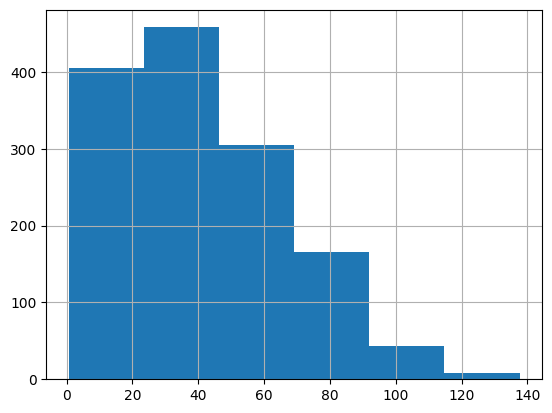

In [ ]:
data_discretization['Value'].hist(bins=6)

bins = pd.cut(data_discretization['Value'],6)
bins.value_counts(sort=False)

# bins = pd.qcut(data_discretization['Value'],6)
# bins.value_counts(sort=False)

## 9.4: PCA


Since the goal of PCA is to transform a high dimensional dataframe into a low dimensional one, considering the fact that we only have three numerical attributes, we decided to not implement it for the main part of the preprocessing. The following two sections show PCA for our dataframe:

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x = data2.drop('Species', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

df_pca = pd.concat([df_pca, data2['Species']], axis=1)

print("DataFrame after PCA:")
print(df_pca)

DataFrame after PCA:
           PC1       PC2  Species
0    -0.254178  1.890776        3
1     0.342642  1.733973        3
2    -1.610304  0.834203        1
3    -1.493321 -1.070964        0
4    -0.094695 -1.218454        2
...        ...       ...      ...
1379 -0.030792 -1.603030        3
1380  1.233981  0.340587        2
1381 -1.453612  0.156334        0
1382  3.347133 -0.371647        2
1383 -1.814819 -0.443495        0

[1384 rows x 3 columns]


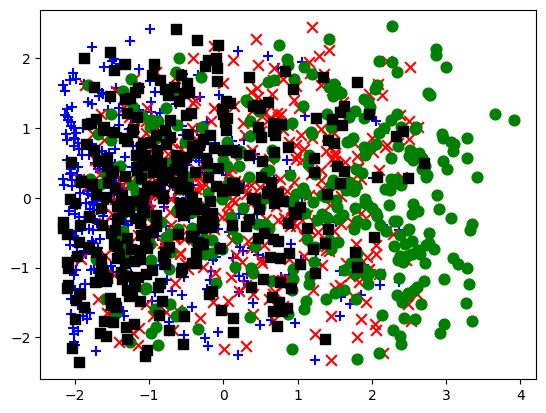

In [ ]:
import matplotlib.pyplot as plt

colors = {0:'b', 1:'r', 2:'g', 3:'k'}
markerTypes = {0:'+', 1:'x', 2:'o', 3:'s'}

for item in markerTypes:
    d = df_pca[df_pca['Species']==item]
    plt.scatter(d['PC1'],d['PC2'],c=colors[item],s=60,marker=markerTypes[item])